In [24]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
import requests, zipfile, io
from zipfile import ZipFile
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',100)

Loading in the higher resolution (10m) Natural Earth data and plotting it

<AxesSubplot:>

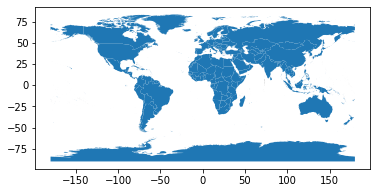

In [25]:
ne_10m = 'https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip'

r = requests.get(ne_10m)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("data/countries/")

world = gpd.read_file('data/countries/ne_10m_admin_0_countries.shp')

world.plot()

Read in the UCDP data

In [26]:
xy_file = ZipFile("data/ged211.csv.zip")

df = pd.read_csv(xy_file.open('ged211.csv'), low_memory=False)


Load in the UCDP data and convert it to a GeoDataFrame (so it can be mapped and used in spatial analysis). The 'wkt.loads' function takes the coordinates in the 'geometry' column and ensures geopandas will use it to map the data.

In [27]:
df_geo = df[['id','geom_wkt']]
df_geo.rename(columns={"geom_wkt":"geometry"}, inplace=True)
df_geo['geometry'] = df_geo['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df_geo, crs='epsg:4326')

/Users/fionaspooner/.pyenv/versions/3.9.7/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/var/folders/yc/bkg2k6pj6td2tpkj64v1yvbr0000gn/T/ipykernel_29446/3465517453.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_geo['geometry'] = df_geo['geometry'].apply(wkt.loads)


Plot the UCDP data points on the world map to check it looks sensible

<AxesSubplot:>

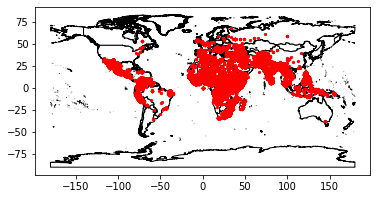

In [28]:
base = world.plot(color='white', edgecolor='black')
gdf.plot(ax=base, marker='o', color='red', markersize=5)


Use the overlay function to extract data from the world map that each point sits on top of.

In [29]:
ucdp_ne = gpd.overlay(gdf, world, how='intersection')


Checking we have extracted a country value for each point - if we have the number of rows in the dataframes will be the same.

In [30]:

ucdp_ne.shape[0] == df.shape[0]

False

There are 1605 points that are missed - likely because they are in the sea perhaps due to the conflict either happening at sea or at the coast and the coordinates are slightly inaccurate. 

In [31]:
df.shape[0] - ucdp_ne.shape[0]

1605

Identifying which points have not yet been assigned a country

In [32]:
ucdp_orig = gdf.id.to_list() 
ucdp_ex = ucdp_ne.id.to_list()

main_list = list(set(ucdp_orig) - set(ucdp_ex))


In [33]:
missing_pts = gdf[gdf.id.isin(main_list)]


Reprojecting the points and the world into the World Equidistant Cylindrical Sphere projection.

In [34]:
wec_crs = '+proj=eqc +lat_ts=0 +lat_0=0 +lon_0=0 +x_0=0 +y_0=0 +a=6371007 +b=6371007 +units=m +no_defs'
missing_pts_wec = missing_pts.to_crs(wec_crs)
world_wec = world.to_crs(wec_crs)

For these points we can find the nearest country using the distance function

In [35]:
polygon_near = []
for index, row in missing_pts_wec.iterrows():
    polygon_index = world_wec.distance(row['geometry']).sort_values().index[0]
    country_name = world_wec['NAME'][polygon_index]
    polygon_near.append(country_name)


Assigning the closest countries to the missing_pts data frame

In [37]:
missing_pts['NAME'] = polygon_near

/Users/fionaspooner/.pyenv/versions/3.9.7/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [38]:
missing_pts.head()

,id,geometry,NAME
36971,5921,POINT (3.01148 36.81745),Algeria
36987,4746,POINT (2.92185 36.80277),Algeria
36988,5336,POINT (3.16667 36.75000),Algeria
37004,5755,POINT (3.91311 36.91716),Algeria
37149,5955,POINT (2.84389 36.76111),Algeria


Merging the extracted countries (ucdp_ne) back into the original dataframe and noting the method used - 'Intersect'

In [39]:
df_intersect = df.merge(ucdp_ne[["id", "NAME"]], on = "id")
df_intersect.rename(columns = {"NAME":"country_name"}, inplace = True)
df_intersect['method'] = 'Intersect'

Merging the extracted countries (missing_pts) back into the original dataframe and noting the method used - 'Nearest'

In [40]:
df_nearest = df.merge(missing_pts[["id", "NAME"]], on = "id")
df_nearest.rename(columns = {"NAME":"country_name"}, inplace = True)
df_nearest['method'] = 'Nearest'

We now have data for all the UCDP points - we can check this by seeing if our dataframe with extracted countries has the same number of rows as the original dataframe.

In [41]:
df_country= df_intersect.append(df_nearest).reset_index()


df_country.shape[0] == df.shape[0]


True

To align with OWID borders we will rename the 152 conflicts in Somaliland to Somalia and the five conflicts in Morocco that were below 27.66727 latitude to Western Sahara.

In [42]:
print(f"{len(df_country.loc[(df_country.country_name == 'Somaliland'),'country_name'])} datapoints in Somaliland")
df_country.loc[(df_country.country_name == 'Somaliland'),'country_name'] = 'Somalia'
print(f"{len(df_country.loc[(df_country.country_name == 'Morocco') & (df_country.latitude < 27.66727),'country_name'])} datapoints in land contested by Morocco/W.Sahara")
df_country.loc[(df_country.country_name == 'Morocco') & (df_country.latitude < 27.66727),'country_name'] = "Western Sahara"

152 datapoints in Somaliland
5 datapoints in land contested by Morocco/W.Sahara


I've added a flag column for points which I think are likely to have incorrect coordinates - points where latitude and longitude are exactly the same, or both 0.

In [43]:
df_country['flag'] = ""
df_country['flag'][df_country['geom_wkt'] == 'POINT (0 0)'] = 'Coordinates 0,0'
df_country['country_name'][df_country['geom_wkt'] == 'POINT (0 0)'] = ""

/var/folders/yc/bkg2k6pj6td2tpkj64v1yvbr0000gn/T/ipykernel_29446/952268017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['flag'][df_country['geom_wkt'] == 'POINT (0 0)'] = 'Coordinates 0,0'
/var/folders/yc/bkg2k6pj6td2tpkj64v1yvbr0000gn/T/ipykernel_29446/952268017.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['country_name'][df_country['geom_wkt'] == 'POINT (0 0)'] = ""


In [45]:
df_country['flag'][df_country.latitude == df_country.longitude] = "Latitude and Longitude same"
df_country['country_name'][df_country.latitude == df_country.longitude] = ""

/var/folders/yc/bkg2k6pj6td2tpkj64v1yvbr0000gn/T/ipykernel_29446/342242140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['flag'][df_country.latitude == df_country.longitude] = "Latitude = Longitude"
/var/folders/yc/bkg2k6pj6td2tpkj64v1yvbr0000gn/T/ipykernel_29446/342242140.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['country_name'][df_country.latitude == df_country.longitude] = ""


Saving the output to a zipped csv

In [46]:
df_country.to_csv('data/ucdp_with_country.csv.zip', index = False, compression = "gzip")